## Under-sampling Method Comparison

We will determine if the different under-sampling algorithms discussed in this section improve the performance of Random Forests on different datasets with imbalanced classes.

In [4]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)

In [5]:
undersampler_dict = {

    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    'cnn': CondensedNearestNeighbour(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=4),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'enn': EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'renn': RepeatedEditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        max_iter=100),

    'allknn': AllKNN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'ncr': NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        n_jobs=4,
        threshold_cleaning=0.5),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=4),

    'nm2': NearMiss(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=4),

    'iht': InstanceHardnessThreshold(
        estimator=LogisticRegression(random_state=0),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=4,
        cv=3)
}

In [6]:
datasets_ls = [

    'ozone_level'
]

In [7]:
# print class imbalance

for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

ozone_level
Counter({np.int64(-1): 2463, np.int64(1): 73})



In [8]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=3, n_jobs=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests pr-auc: {}'.format(average_precision_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests pr-auc: {}'.format(average_precision_score(y_test, pred[:, 1])))

    return average_precision_score(y_test, pred[:, 1])

In [9]:
# to save the results
results_dict = {}
shapes_dict = {}

for dataset in datasets_ls:

    results_dict[dataset] = {}
    shapes_dict[dataset] = {}

    print(dataset)

    # load dataset
    data = fetch_datasets()[dataset]

    # separate train and test
    X_train, X_test, y_train, y_test = train_test_split(
    data.data,
    data.target,
    test_size=0.3,
    random_state=0)

    # as many undersampling techniques use KNN
    # we set variables in the same scale
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    roc = run_randomForests(X_train, X_test, y_train, y_test)

    # store results
    results_dict[dataset]['full_data'] = roc
    shapes_dict[dataset]['full_data'] = len(X_train)

    print()

    for undersampler in undersampler_dict.keys():

        print(undersampler)

        # resample
        X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)

        # evaluate performance
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)

        #store results
        results_dict[dataset][undersampler] = roc
        shapes_dict[dataset][undersampler] = len(X_resampled)
        print()

    print()


ozone_level
Train set
Random Forests pr-auc: 0.661091778839447
Test set
Random Forests pr-auc: 0.1184649900279849

random
Train set
Random Forests pr-auc: 0.9896289799036716
Test set
Random Forests pr-auc: 0.16446953664232122

cnn
Train set
Random Forests pr-auc: 0.9087752043919196
Test set
Random Forests pr-auc: 0.11863276520108736

tomek
Train set
Random Forests pr-auc: 0.6693804318470666
Test set
Random Forests pr-auc: 0.11969459315298396

oss
Train set
Random Forests pr-auc: 0.6809603517753406
Test set
Random Forests pr-auc: 0.10860155901934407

enn
Train set
Random Forests pr-auc: 0.7177977420397367
Test set
Random Forests pr-auc: 0.13239124680096348

renn
Train set
Random Forests pr-auc: 0.7764080188927531
Test set
Random Forests pr-auc: 0.12219014477425068

allknn
Train set
Random Forests pr-auc: 0.7528482253558497
Test set
Random Forests pr-auc: 0.12664388819213832

ncr
Train set
Random Forests pr-auc: 0.7193094854609816
Test set
Random Forests pr-auc: 0.12011146786093171

nm1


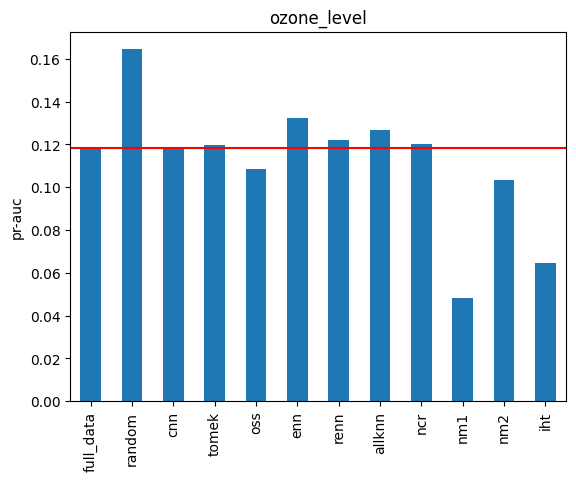

In [10]:
for dataset in datasets_ls:

    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('pr-auc')
#     plt.ylim(0.55, 0.9)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

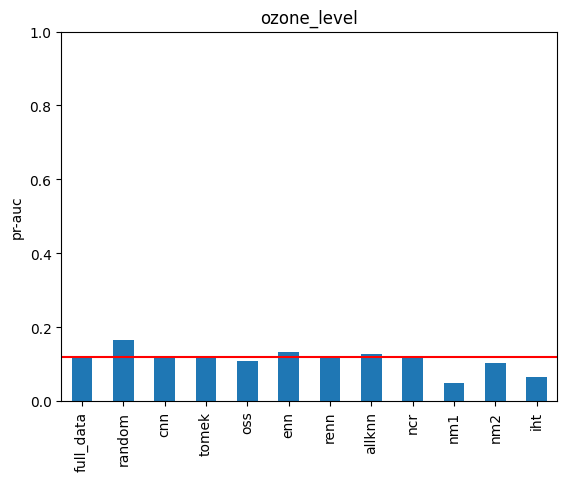

In [11]:
for dataset in datasets_ls:

    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('pr-auc')
    plt.ylim(0, 1)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

**Different under-sampling techniques work best for different datasets.**

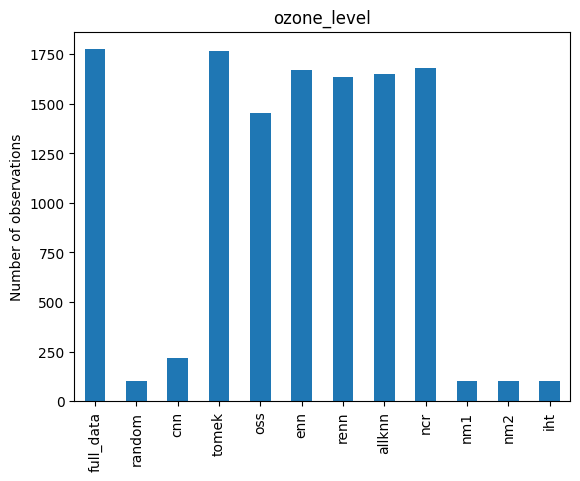

In [12]:
for dataset in datasets_ls:

    pd.Series(shapes_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('Number of observations')
    plt.show()

In [13]:
data = fetch_datasets()['ozone_level']